# Importing

In [1]:
import os,sys,types
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
import numpy as np
import h5py
import glob
import pandas
import itertools
from six import string_types,reraise
os.environ.update

from utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/home/castello/ML_classifier/my_repository/CMS_Deep_Learning"))

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, LocallyConnected1D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.utils import plot_model

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [3]:
from CMS_Deep_Learning.io import repr_structure, retrieve_data, nb_samples_from_h5, \
                    gen_from_data, simple_grab, restructure, flatten, assert_list, DataIterator
import glob

# Grab the datasets (both training and validation ones)

In [4]:
example_dir = '/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des' ## shuffled dataset
ex_subset = glob.glob(example_dir + "/val/*.h5")[:2]
#ex_subset = glob.glob(example_dir + "/val/*.h5")

In [5]:
ex_subset ## this is a subset of two files

['/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/val/000.h5',
 '/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/val/001.h5']

In [6]:
X,Y = simple_grab(['X','Y'], data=example_dir +"/train",
           input_keys='HLF',label_keys='Labels')
print(X.shape, Y.shape)

(330000, 14) (330000, 3)


In [7]:
Xval,Yval = simple_grab(['X','Y'], data=example_dir +"/val",
           input_keys='HLF',label_keys='Labels')
print(Xval.shape, Yval.shape)

(52500, 14) (52500, 3)


# Checking the dataset content

In [8]:
myfile = h5py.File("/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/val/000.h5")

In [9]:
datasetIN = myfile.get('HLF')

In [10]:
type(datasetIN)

h5py._hl.dataset.Dataset

# Printing the content of the two shuffled datasets  

In [11]:
print(X) ## This is the input: the 14 HLF features

[[   0.           19.37954521   -1.16373146 ...,    0.           -1.            0.        ]
 [  64.71331787   25.43550491   -2.05074644 ...,    0.           -1.            1.        ]
 [ 107.83158493   44.87385559    2.61842871 ...,    0.           -1.            1.        ]
 ..., 
 [  45.58285904   30.4067955    -1.67194188 ...,    0.            1.            1.        ]
 [   0.           20.80108452    0.27870378 ...,    0.           -1.            1.        ]
 [   0.           28.23332596    2.63427138 ...,    0.            1.            1.        ]]


In [12]:
print(Y) ## This is the target: it tells you to which dataset the original event was belonging to.

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 ..., 
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


# Normalizing the input between 0 and 1 (for both training and validation)

In [13]:
maxXValues = np.max(X, axis=0)
minXValues = np.min(X, axis=0)

In [14]:
normX = np.nan_to_num((X[:,:]-minXValues)/(maxXValues-minXValues))

In [15]:
normX.shape

(330000, 14)

In [16]:
maxXvalValues = np.max(Xval, axis=0)
minXvalValues = np.min(Xval, axis=0)

In [17]:
normXval = np.nan_to_num((Xval[:,:]-minXvalValues)/(maxXvalValues-minXvalValues))

In [18]:
normXval.shape

(52500, 14)

# Function to draw

In [19]:
def show_losses( histories ):
   # doing nothing for the moment, but it will do 
    return

# Calculating the accuracy (to decide which model performs better)

In [20]:
def accuracy( p ):
    p_cat = np.argmax(p,axis=1)
    target_cat = np.argmax(Yval,axis=1)
    print("Number and fraction of good prediction")
    print(len(np.where( p_cat == target_cat )[0]))
    print(len(np.where( p_cat == target_cat )[0])/float(len(p_cat)),"%")


# Compiling and training the networks

## Model 1 

In [ ]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(50, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(20, input_shape=(50,), activation='sigmoid')(l1)
l3 = Dense(10, input_shape=(20,), activation='sigmoid')(l2)
out = Dense(3, input_shape=(10,), activation='softmax')(l3) # sigmoid is needed as dealing with the output between 0 and 1 
# Specifying here the input and output of a model --> Model(input, output)
ffNN = Model(inp,out) 
# comment: 4 Layers of 50,20,10,3 nodes (starting from 6 and then following a representation 50-dim, 20-dim, 10-dim)
ffNN.summary()
ffNN.compile(optimizer='RMSprop', loss='categorical_crossentropy') 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=50, verbose=1, validation_data=(normXval,Yval))
# crossentropy loss function is usually used in classificaation
# Training over normX sample and validating over normXval
# serialize model to JSON
mod1 = ffNN.to_json()
with open("trained_networks/model_1.json", "w") as json_file:
    json_file.write(mod1)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_1.h5")
print("Saved model to disk")


In [ ]:
print(histo.history.keys())

In [ ]:
# summarize history for loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
accuracy(ffNN.predict(normXval))

## Model 2

In [ ]:
# Add a method to stop training when validation is getting worse
from keras.callbacks import EarlyStopping

In [ ]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(50, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(20, input_shape=(50,), activation='sigmoid')(l1)
l3 = Dense(10, input_shape=(20,), activation='sigmoid')(l2)
out = Dense(3, input_shape=(10,), activation='softmax')(l3) # sigmoid is needed as dealing with the output between 0 and 1 
# Specifying here the input and output of a model --> Model(input, output)
ffNN = Model(inp,out) 
# comment: 4 Layers of 50,20,10,3 nodes (starting from 6 and then following a representation 50-dim, 20-dim, 10-dim)
ffNN.summary()
ffNN.compile(optimizer='RMSprop', loss='categorical_crossentropy') 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=50, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3, verbose=0, mode='min')], verbose=1, validation_data=(normXval,Yval))
mod2 = ffNN.to_json()
with open("trained_networks/model_2.json", "w") as json_file:
    json_file.write(mod2)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_2.h5")
print("Saved model to disk")

In [ ]:
# summarize history for loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
accuracy(ffNN.predict(normXval))

## Model 3

In [ ]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(50, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(20, input_shape=(50,), activation='sigmoid')(l1)
l3 = Dense(10, input_shape=(20,), activation='sigmoid')(l2) 
out = Dense(3, input_shape=(10,), activation='softmax')(l3)
ffNN = Model(inp,out) 
# comment: 4 Layers of 50,20,10,3 nodes (starting from 14-dim and then following a representation 50-dim, 20-dim, 10-dim)
ffNN.summary()
ffNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=50, verbose=1, validation_data=(normXval,Yval))
mod3 = ffNN.to_json()
with open("trained_networks/model_3.json", "w") as json_file:
    json_file.write(mod3)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_3.h5")
print("Saved model to disk")

In [ ]:
# loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
# accuracy
plt.plot(histo.history['acc'])
plt.plot(histo.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
accuracy(ffNN.predict(normXval))

In [ ]:
# A look at the output of the ffNN: set of probability (the highest means the best choice, and depending on the position it can be tt, QCD or W+jets)
print(ffNN.predict(normXval))

# Confusion matrix

In [ ]:
# Make confusion matrix
confu_matrix = np.zeros((3,3))
print(confu_matrix)
#plot_confusion_matrix(confu_matrix,['QCD','TTbar','W+jets'],title='Confusion Matrix')

# ROC curve

In [ ]:
## Make ROC curve
prob = ffNN.predict(normXval)
print(prob[:,1])
print(Yval[:,1])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Yval[:,1], prob[:, 1])
# with the [:,1] we extract only the results of the column of ttbar [0,1,0]
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="DenseNN HLF (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
plt.show()
#print(thresholds)
#print(fpr)

In [ ]:
# 1- FPR ( at TPR=0.95) 
print(1-fpr[np.where((tpr >=0.94999) & (tpr <=0.950100000))[0]])
# 1- FPR ( at TPR=0.90) 
print(1-fpr[np.where((tpr >=0.89999) & (tpr <=0.900100000))[0]])

# Model 4

In [ ]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(200, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(50, input_shape=(200,), activation='sigmoid')(l1)
out = Dense(3, input_shape=(50,), activation='softmax')(l2) # sigmoid is needed as dealing with the output between 0 and 1 
# Specifying here the input and output of a model --> Model(input, output)
ffNN = Model(inp,out) 
# comment: 4 Layers of 50,20,10,3 nodes (starting from 6 and then following a representation 50-dim, 20-dim, 10-dim)
ffNN.summary()
ffNN.compile(optimizer='adam', loss='categorical_crossentropy') 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=50, verbose=1, validation_data=(normXval,Yval))

In [ ]:
## Make ROC curve
prob = ffNN.predict(normXval)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Yval[:,1], prob[:, 1])
# with the [:,1] we extract only the results of the column of ttbar [0,1,0]
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="DenseNN HLF (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
plt.show()
#print(thresholds)
#print(fpr)

In [ ]:
# 95% 
print(fpr[np.where((tpr >=0.94999) & (tpr <=0.950100000))[0]])

# Model 5 (as model 3 but w/ dropout layer)

In [21]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(50, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(20, input_shape=(50,), activation='sigmoid')(l1)
l3 = Dense(10, input_shape=(20,), activation='sigmoid')(l2) 
ldrop = Dropout(0.4)(l3)
out = Dense(3, input_shape=(10,), activation='softmax')(ldrop)
ffNN = Model(inp,out) 
# comment: 4 Layers of 50,20,10,3 nodes (starting from 14-dim and then following a representation 50-dim, 20-dim, 10-dim)
ffNN.summary()
ffNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=150, verbose=1, validation_data=(normXval,Yval))
mod5 = ffNN.to_json()
with open("trained_networks/model_5.json", "w") as json_file:
    json_file.write(mod5)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_5.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________
Train on

330000/330000 [==============================] - 3s - loss: 0.4936 - acc: 0.8044 - val_loss: 0.4866 - val_acc: 0.7980
Epoch 55/150
330000/330000 [==============================] - 4s - loss: 0.4920 - acc: 0.8045 - val_loss: 0.4843 - val_acc: 0.7982
Epoch 56/150
330000/330000 [==============================] - 4s - loss: 0.4915 - acc: 0.8047 - val_loss: 0.4831 - val_acc: 0.7972
Epoch 57/150
330000/330000 [==============================] - 3s - loss: 0.4900 - acc: 0.8055 - val_loss: 0.4919 - val_acc: 0.7912
Epoch 58/150
330000/330000 [==============================] - 4s - loss: 0.4907 - acc: 0.8056 - val_loss: 0.4953 - val_acc: 0.7885
Epoch 59/150
330000/330000 [==============================] - 4s - loss: 0.4914 - acc: 0.8056 - val_loss: 0.4905 - val_acc: 0.7914
Epoch 60/150
330000/330000 [==============================] - 4s - loss: 0.4905 - acc: 0.8054 - val_loss: 0.4997 - val_acc: 0.7897
Epoch 61/150
330000/330000 [==============================] - 4s - loss: 0.4890 - acc: 0.8063 - 

330000/330000 [==============================] - 4s - loss: 0.4295 - acc: 0.8364 - val_loss: 0.4274 - val_acc: 0.8259
Epoch 117/150
330000/330000 [==============================] - 4s - loss: 0.4299 - acc: 0.8372 - val_loss: 0.4130 - val_acc: 0.8336
Epoch 118/150
330000/330000 [==============================] - 4s - loss: 0.4286 - acc: 0.8378 - val_loss: 0.4195 - val_acc: 0.8332
Epoch 119/150
330000/330000 [==============================] - 4s - loss: 0.4288 - acc: 0.8383 - val_loss: 0.4321 - val_acc: 0.8255
Epoch 120/150
330000/330000 [==============================] - 4s - loss: 0.4274 - acc: 0.8379 - val_loss: 0.4395 - val_acc: 0.8198
Epoch 121/150
330000/330000 [==============================] - 4s - loss: 0.4270 - acc: 0.8387 - val_loss: 0.4427 - val_acc: 0.8232
Epoch 122/150
330000/330000 [==============================] - 4s - loss: 0.4278 - acc: 0.8379 - val_loss: 0.4399 - val_acc: 0.8220
Epoch 123/150
330000/330000 [==============================] - 4s - loss: 0.4268 - acc: 0.

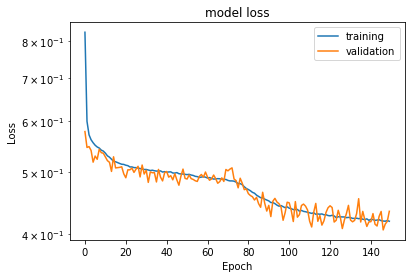

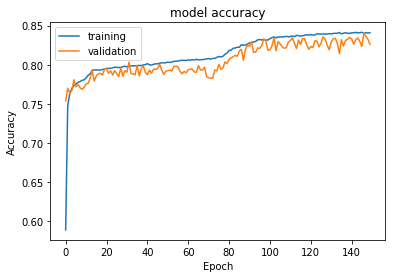

In [22]:
# loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.savefig("Loss_HLF.pdf")
plt.savefig("Loss_HLF.png")
plt.show()
# accuracy
plt.plot(histo.history['acc'])
plt.plot(histo.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

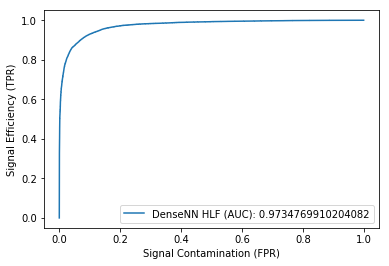

In [23]:
## Make ROC curve
prob = ffNN.predict(normXval)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Yval[:,1], prob[:, 1])
# with the [:,1] we extract only the results of the column of ttbar [0,1,0], i.e our signal
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="DenseNN HLF (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
plt.savefig("ROC_HLF.pdf")
plt.savefig("ROC_HLF.png")
plt.show()
np.save("FPR", fpr)
np.save("TPR", tpr)
with h5py.File("HLF_ROC.h5","w") as roc_file:
    roc_file.create_dataset("FPR", data=fpr)
    roc_file.create_dataset("TPR", data=tpr)
#print(thresholds)
#print(fpr)

### Retrieving the table for the paper

In [ ]:
from CMS_Deep_Learning.postprocessing.metrics import get_roc_points
import pandas as pd

# Indicies are in alphabetical order
QCD, TTBAR, WJETS = 0, 1, 2 ;

class_labels = {QCD:'QCD',TTBAR:r'$t\bar{t}$', WJETS:"W+jets"}
fix_tprs = []
fix_fprs = []

HLF_ROC_points = get_roc_points(
                    Y=Yval,
                    predictions=prob,
                    class_labels=class_labels,
                    true_class_index=TTBAR,
                    tpr=tpr,
                    fpr=fpr,
                    class_fprs={QCD: [.1]})
                   # class_fprs={QCD: [.0001,.00025,.0005,.001, .0015,.002, .0025,.005,.01,.025,.05,.075,.1]})


#HLF_ROC_points = pd.DataFrame(HLF_ROC_points, columns=['tpr','fpr','fpr:W+jets','fpr:QCD','thresh'])
#HLF_ROC_points.to_hdf("HLF_ROC_points.h5","ROC_Points")

#print("HLF: TPRS and FPRS in percents(%)")
#print(100*HLF_ROC_points)

In [ ]:
print(HLF_ROC_points)

In [24]:
# 1- FPR ( at TPR=0.95) 
print(1-fpr[np.where((tpr >=0.94999) & (tpr <=0.95050000))[0]])
# 1- FPR ( at TPR=0.90) 
print(1-fpr[np.where((tpr >=0.89999) & (tpr <=0.90010000))[0]])

[ 0.86557143  0.86554286  0.86554286  0.86548571  0.86542857  0.86542857
  0.86537143  0.86531429  0.86514286  0.86514286  0.86505714  0.86505714
  0.865       0.865       0.86497143  0.86497143  0.86488571  0.86482857
  0.86477143]
[ 0.93022857  0.9302      0.9302      0.93017143]


# Model 6 (w/ ReduceLROnPlateau and EarlyStopping)

In [ ]:
#Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(50, input_shape=(14,), activation='sigmoid')(inp)
l2 = Dense(20, input_shape=(50,), activation='sigmoid')(l1)
l3 = Dense(10, input_shape=(20,), activation='sigmoid')(l2) 
ldrop = Dropout(0.4)(l3)
out = Dense(3, input_shape=(10,), activation='softmax')(ldrop)
ffNN = Model(inp,out) 
ffNN.summary()
ffNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
## Reduce LR on Plateau and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001)
histo = ffNN.fit(normX, Y, callbacks=[reduce_lr,early_stop], batch_size=100, epochs=150, verbose=1, validation_data=(normXval,Yval))
mod6 = ffNN.to_json()
with open("trained_networks/model_6.json", "w") as json_file:
    json_file.write(mod6)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_6.h5")
print("Saved model to disk")

In [ ]:
# loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.savefig("Loss_HLF.pdf")
plt.savefig("Loss_HLF.png")
plt.show()
# accuracy
plt.plot(histo.history['acc'])
plt.plot(histo.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
## Make ROC curve
prob = ffNN.predict(normXval)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Yval[:,1], prob[:, 1])
# with the [:,1] we extract only the results of the column of ttbar [0,1,0], i.e our signal
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="DenseNN HLF (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
#plt.savefig("ROC_HLF.pdf")
#plt.savefig("ROC_HLF.png")
plt.show()
#np.save("FPR", fpr)
#np.save("TPR", tpr)
#with h5py.File("HLF_ROC.h5","w") as roc_file:
#    roc_file.create_dataset("FPR", data=fpr)
#    roc_file.create_dataset("TPR", data=tpr)
#print(thresholds)
#print(fpr)

# Model 7 (w/ Thong's optimizer, still with epoch 100!)

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.models import model_from_json
from utils.create_model import create_model

#load json and create model
#json_file = open('trained_networks/model_5.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
#load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
#template_model = create_model()

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=1000, verbose=1)
init_size = [1800, 1900]
layers = [3]
optimizer = ['Nadam',"Adam","RMSprop","SGD"]
param_grid = dict(init_size=init_size, layers=layers, optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=1)
grid_result = grid.fit(normX,Y)

# summarize results
print("Best: %f using %s with estimator %s" % (grid_result.best_score_, grid_result.best_params_, grid_result.best_estimator_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



# Model 8 (after optimization)

In [ ]:
# Defining here the layers
inp = Input(shape=(14,))
l1 = Dense(1900, input_shape=(14,), activation='sigmoid')(inp)
ldrop1 = Dropout(0.4)(l1)
l2 = Dense(950, input_shape=(1900,), activation='sigmoid')(ldrop1)
ldrop2 = Dropout(0.4)(l2)
l3 = Dense(475, input_shape=(950,), activation='sigmoid')(ldrop2) 
ldrop3 = Dropout(0.4)(l3)
out = Dense(3, input_shape=(475,), activation='softmax')(ldrop3)
ffNN = Model(inp,out) 
ffNN.summary()
ffNN.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy']) 
histo = ffNN.fit(normX, Y, batch_size=100, epochs=150, verbose=1, validation_data=(normXval,Yval))
mod5 = ffNN.to_json()
with open("trained_networks/model_8.json", "w") as json_file:
    json_file.write(mod5)
# serialize weights to HDF5
ffNN.save_weights("trained_networks/model_8.h5")
print("Saved model to disk")

### Loss and accuracy

In [ ]:
# loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.savefig("Loss_HLF.pdf")
plt.savefig("Loss_HLF.png")
plt.show()
# accuracy
plt.plot(histo.history['acc'])
plt.plot(histo.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

### ROC curve

In [ ]:
## Make ROC curve
prob = ffNN.predict(normXval)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Yval[:,1], prob[:, 1])
# with the [:,1] we extract only the results of the column of ttbar [0,1,0], i.e our signal
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="DenseNN HLF (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
plt.savefig("ROC_HLF.pdf")
plt.savefig("ROC_HLF.png")
plt.show()
np.save("FPR", fpr)
np.save("TPR", tpr)
with h5py.File("HLF_optimized_ROC.h5","w") as roc_file:
    roc_file.create_dataset("FPR", data=fpr)
    roc_file.create_dataset("TPR", data=tpr)
#print(thresholds)

In [ ]:
# 1- FPR ( at TPR=0.95) 
print(1-fpr[np.where((tpr >=0.94999) & (tpr <=0.95050000))[0]])
# 1- FPR ( at TPR=0.90) 
print(1-fpr[np.where((tpr >=0.89999) & (tpr <=0.900100000))[0]])